### Import necessary libraries and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from keras.preprocessing import image
#from tensorflow.keras.utils import img_to_array
from keras.utils import load_img, img_to_array
import tensorflow as tf
import seaborn as sns
import cv2
from tensorflow.keras import layers, models

import csv
import re

from sklearn.model_selection import cross_val_score, StratifiedKFold,cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc,confusion_matrix,classification_report


# import json

### Load the excel sheet and CESM image location - to load the dataset and labels to array

In [2]:
#mycsv = csv.reader(open("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD.csv"))
# df = pd.read_excel("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD_train.xlsx")
df = pd.read_excel("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD.xlsx")
#df = pd.read_excel("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD-CESM-Train.xlsx")
#df

from os.path import exists
patientID=[]
y_train = []

### pathh for the subtracted energy images and path for the low energy images
pathh='C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD-CESM\\Subtracted images of CDD-CESM\\'
path='C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD-CESM\\Low energy images of CDD-CESM\\'

SIZE= 224

train_images = []
train_labels = []
train_dhe=[]

### Functions for the data augmentation - flip, translation, and rotation

In [3]:
def flip_image(image, direction='vertical'):
    """
    Flip the input image vertically or horizontally.

    Parameters:
    - image: Input image as a NumPy array.
    - direction: Direction of flipping, either 'vertical' or 'horizontal'.
                 Default is 'vertical'.

    Returns:
    - Flipped image as a NumPy array.
    """

    # Perform vertical flipping
    if direction == 'vertical':
        flipped_image = cv2.flip(image, 0)
    # Perform horizontal flipping
    elif direction == 'horizontal':
        flipped_image = cv2.flip(image, 1)
    else:
        raise ValueError("Invalid direction. Choose either 'vertical' or 'horizontal'.")

    return flipped_image

In [4]:
def translate_image(image, dx, dy):
    """
    Apply translation (shifting) augmentation to a single image.
    
    Args:
    - image: Input image (numpy array).
    - dx: Horizontal shift distance (in pixels).
    - dy: Vertical shift distance (in pixels).
    
    Returns:
    - Translated image (numpy array).
    """
    # Define translation matrix
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    # Apply translation to the image
    translated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return translated_image

In [5]:
def rotate_image(image, angle):
    """
    Rotate an image by a given angle.

    Args:
        image (numpy.ndarray): Input image.
        angle (float): Rotation angle in degrees.

    Returns:
        numpy.ndarray: Rotated image.
    """
    # Get image dimensions
    height, width = image.shape[:2]
    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    # Apply rotation to image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

### Loading the dataset (only birads 4 category) and labels

In [6]:
# loop to each row(i.e. each patients instances) then:
#    select only the rows with BI-RADS 4 category 
#    check if the image name of the the selected rows existing in the folder (path)
#    load the image , if it exists then preprocess
#    ptherwise skip to the next row



for index, row in df.iterrows():
    if row["BIRADS"]  == 4 or row["BIRADS"]  == "4$2" or row["BIRADS"]  == "4$3" or row["BIRADS"]  == "4"  :
        if exists(path + str(row["Image_name"]) + ".jpg") == False:
            continue

        y_train.append(row["Pathology Classification/ Follow up"])
        patientID.append(row["Image_name"])


        img = cv2.imread(path + str(row["Image_name"]) + ".jpg", cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE,SIZE))

        img = img_to_array(img)
        img = img.astype(np.uint8)
        rt = rotate_image(img, 180)
        
        
        ###To have a balance dataset apply vertical and horizontal flippings as well as translation to the dataset
        if row["Pathology Classification/ Follow up"] == "Benign" or row["Pathology Classification/ Follow up"] == 'Normal':
            vf = flip_image(img, direction='vertical')
            hf = flip_image(img, direction='horizontal')
            ti = translate_image(img, dx=20, dy=-10)
            ti2 = translate_image(rt, dx=-10, dy=20)
            

            train_images.append(vf)
            train_labels.append(row["Pathology Classification/ Follow up"])

# #             train_images.append(df)
# #             train_labels.append(row["Pathology Classification/ Follow up"])
            
            train_images.append(hf)
            train_labels.append(row["Pathology Classification/ Follow up"])
            
            train_images.append(ti)
            train_labels.append(row["Pathology Classification/ Follow up"])
            
            train_images.append(ti2)
            train_labels.append(row["Pathology Classification/ Follow up"])  
            
#             train_images.append(rt)
#             train_labels.append(row["Pathology Classification/ Follow up"])

#            fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(10,3.5))
#            ax[0].imshow(img)
#            ax[0].set_title('Orignal')
#            ax[0].axis('off')
            
            
#            ax[1].imshow(rt)
#            ax[1].set_title('Rotate')
#            ax[1].axis('off')

#             ax[1].imshow(CLAHE_img)
#             ax[1].set_title('CLAHE')
#             ax[1].axis('off')


#             ax[2].imshow(hf)
#             ax[2].set_title('Horizontal')
#             ax[2].axis('off')

#             ax[3].imshow(vf)
#             ax[3].set_title('Vertical')
#             ax[3].axis('off')



        #except:
        #break
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #train_dhe.append(result)
        train_images.append(img)
        train_labels.append(row["Pathology Classification/ Follow up"])


        train_images.append(rt)
        train_labels.append(row["Pathology Classification/ Follow up"])
   
#     if index==328:
#         break

In [7]:
### just to confirm the number of instances for each image

from collections import Counter

# Count the unique instances in y_train
y_train_counter = Counter(train_labels)

# Print the unique instances and their counts
for pathology, count in y_train_counter.items():
    print(f"{pathology}: {count}")

Malignant: 306
Benign: 234
Normal: 6


### Repeat the same process for the subtracted energy images

In [7]:
# df = pd.read_excel("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD_train.xlsx")
df = pd.read_excel("C:\\Users\\S00243011\\OneDrive - Atlantic TU\\CDD-CESM\\CDD.xlsx")
for index, row in df.iterrows():
    if row["BIRADS"]  == 4 or row["BIRADS"]  == "4$2" or row["BIRADS"]  == "4$3" or row["BIRADS"]  == "4"  :
        #print(row["Right Pathology"])
        if exists(pathh + str(row["Image_name"]) + ".jpg") == False:
           # print(str(row["Image_name"]) + ".jpg")
            continue

        y_train.append(row["Pathology Classification/ Follow up"])
        patientID.append(row["Image_name"])


        img = cv2.imread(pathh + str(row["Image_name"]) + ".jpg", cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE,SIZE))

        img = img_to_array(img)

        img = img.astype(np.uint8)
        

        rt = rotate_image(img, 180)
        
        if row["Pathology Classification/ Follow up"] == "Benign" or row["Pathology Classification/ Follow up"] == 'Normal':
            vf = flip_image(img, direction='vertical')
            hf = flip_image(img, direction='horizontal')
            ti = translate_image(img, dx=20, dy=-10)
            ti2 = translate_image(rt, dx=-10, dy=20)
            

            train_images.append(vf)
            train_labels.append(row["Pathology Classification/ Follow up"])

# #             train_images.append(df)
# #             train_labels.append(row["Pathology Classification/ Follow up"])

            train_images.append(hf)
#             train_images.append(rt)
            train_labels.append(row["Pathology Classification/ Follow up"])
        
            train_images.append(ti)
            train_labels.append(row["Pathology Classification/ Follow up"])        
            
            train_images.append(ti2)
            train_labels.append(row["Pathology Classification/ Follow up"])  
#             train_images.append(rt)
#             train_labels.append(row["Pathology Classification/ Follow up"])

#             fig,ax=plt.subplots(nrows=1, ncols=4, figsize=(10,3.5))
#             ax[0].imshow(img)
#             ax[0].set_title('Orignal')
#             ax[0].axis('off')


#             ax[1].imshow(result)
#             ax[1].set_title('DHE')
#             ax[1].axis('off')

#             ax[1].imshow(CLAHE_img)
#             ax[1].set_title('CLAHE')
#             ax[1].axis('off')


#             ax[2].imshow(hf)
#             ax[2].set_title('Horizontal')
#             ax[2].axis('off')

#             ax[3].imshow(vf)
#             ax[3].set_title('Vertical')
#             ax[3].axis('off')



        #except:
        #break
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #train_dhe.append(result)
        train_images.append(img)
        train_labels.append(row["Pathology Classification/ Follow up"])

#         train_images.append(vf)
#         train_labels.append(row["Pathology Classification/ Follow up"])

#         train_images.append(hf)
#         train_labels.append(row["Pathology Classification/ Follow up"])

        train_images.append(rt)
        train_labels.append(row["Pathology Classification/ Follow up"])
   
#     if index==328:
#         break

In [8]:

### convert normal instances to benign - so binary classification benign/malignant

for i in range(len(train_labels)):
    # Check if the current element is 'n'
    if train_labels[i] == 'Normal':
        # If it is, replace it with 'x'
        train_labels[i] = 'Benign'



### convert the image and label array to numpy array
train_images=np.array(train_images)
train_images.shape

train_labels=np.array(train_labels)
#train_labels.shape

In [9]:
## count the number instances

from collections import Counter

# Count the unique instances in y_train
y_train_counter = Counter(train_labels)

# Print the unique instances and their counts
for pathology, count in y_train_counter.items():
    print(f"{pathology}: {count}")

Malignant: 490
Benign: 444


In [10]:
## hot encode the labels - benign - 0, malignant- 1

train_labels=np.array(train_labels)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels= le.transform(train_labels)
train_labels.shape

(934,)

<Axes: ylabel='count'>

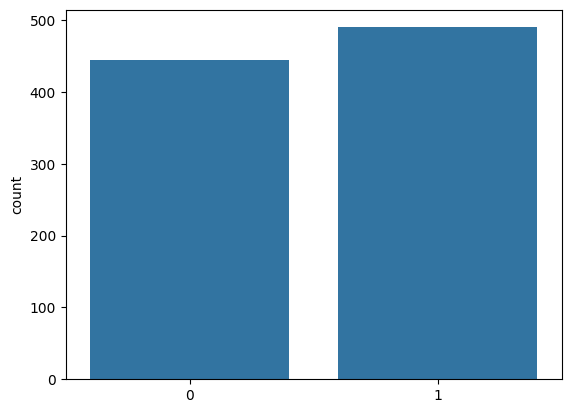

In [11]:
## plot the distribution of the dataset instances

sns.countplot(x=train_labels)

In [12]:
## convert the classes to categorical values

from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

# Assuming your labels are stored in a numpy array called 'labels'
num_classes = 2  # Number of classes
train_labels = to_categorical(train_labels, num_classes)

In [13]:
### split the dataset to training and test sets

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, 
                                                    test_size = 0.20, random_state = 10)
print(x_train.shape, y_val.shape)

(747, 224, 224, 3) (187, 2)


In [14]:
x_train = x_train / 255.0 #normalizing images
x_val = x_val / 255.0 

### Model development and traning

In [ ]:
### import baseline model for feature extraction - this work used MobileNet

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
#from tensorflow.keras.applications import SqueezeNet
#from tensorflow.keras.applications import ShuffleNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetMobile


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,AveragePooling2D,Conv2D,MaxPooling2D,Concatenate,Activation,Multiply
from tensorflow.keras import backend as K

In [16]:
def cbam_block(inputs, reduction_ratio=0.5):
    # Channel attention
    
    
    channels = inputs.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    shared_layer_1 = layers.Dense(units=int(channels * reduction_ratio), activation='relu', use_bias=True)
    shared_layer_2 = layers.Dense(units=channels, activation='relu', use_bias=True)
    avg_pool = shared_layer_1(avg_pool)
    avg_pool = shared_layer_2(avg_pool)
    max_pool = shared_layer_1(max_pool)
    max_pool = shared_layer_2(max_pool)
    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Activation('sigmoid')(attention)
    attention = layers.Reshape((1, 1, channels))(attention)
    scaled_inputs = layers.Multiply()([inputs, attention])

    
    
    
    # Spatial attention
#     squeeze = layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', use_bias=False)(scaled_inputs)
# #     squeeze = layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', use_bias=False)(inputs)
# #     expanded_inputs = layers.Multiply()([inputs, squeeze])
#     expanded_inputs = layers.Multiply()([scaled_inputs, squeeze])
    
    
#     scaled_inputs = inputs
    cap = AveragePooling2D(pool_size=(inputs.shape[1], inputs.shape[2]))(scaled_inputs)
    cap = Conv2D(1, (1, 1), activation='relu')(cap)
    
    # Apply cross-channel max pooling (CMP)
    cmp = MaxPooling2D(pool_size=(inputs.shape[1], inputs.shape[2]))(scaled_inputs)
    cmp = Conv2D(1, (1, 1), activation='relu')(cmp)
    
    # Concatenate feature maps
    concatenated = Concatenate(axis=-1)([cap, cmp])
    
    # Apply ReLU activation
    fused = Activation('relu')(concatenated)
    
    # Apply 1x1 convolution
    weights = Conv2D(1, (1, 1), activation='sigmoid')(fused)
    
    # Element-wise multiplication with input features
    attended_inputs = Multiply()([scaled_inputs, weights])
    
    return attended_inputs

#     return scaled_inputs
#     return expanded_inputs


def Mobil_CBAM():
    input_shape = (224, 224, 3)

    # Create the ResNet50 model
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add the CBAM attention mechanism
    x = base_model.output
    x = cbam_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=2, activation='sigmoid')(x)

    # Combine the ResNet50 model and the attention mechanism
    model = models.Model(inputs=base_model.input, outputs=x, name='Mobil_CBAM')

    return model


model = Mobil_CBAM()
model.summary()

Model: "Mobil_CBAM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']   

In [17]:
# Compile the model
from sklearn.metrics import hinge_loss
from tensorflow.keras.losses import Hinge


# model.compile(optimizer=Adam(), loss=Hinge(), metrics=['binary_accuracy'])
#model.compile(optimizer=Adam(), loss=Hinge(), metrics=['accuracy'])
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

### Model training five fold cross-validation

Training on Fold 1...
Epoch 1/40
38/38 [==============================] - 117s 3s/step - loss: 0.6691 - accuracy: 0.5896 - val_loss: 0.7438 - val_accuracy: 0.4800
Epoch 2/40
38/38 [==============================] - 84s 2s/step - loss: 0.5374 - accuracy: 0.7253 - val_loss: 0.7593 - val_accuracy: 0.6600
Epoch 3/40
38/38 [==============================] - 82s 2s/step - loss: 0.3781 - accuracy: 0.8241 - val_loss: 3.7493 - val_accuracy: 0.4533
Epoch 4/40
38/38 [==============================] - 84s 2s/step - loss: 0.4363 - accuracy: 0.7990 - val_loss: 0.6834 - val_accuracy: 0.6667
Epoch 5/40
38/38 [==============================] - 86s 2s/step - loss: 0.3156 - accuracy: 0.8476 - val_loss: 0.6183 - val_accuracy: 0.7533
Epoch 6/40
38/38 [==============================] - 85s 2s/step - loss: 0.1826 - accuracy: 0.9296 - val_loss: 0.6360 - val_accuracy: 0.7267
Epoch 7/40
38/38 [==============================] - 85s 2s/step - loss: 0.1569 - accuracy: 0.9330 - val_loss: 1.1201 - val_accuracy: 0.68

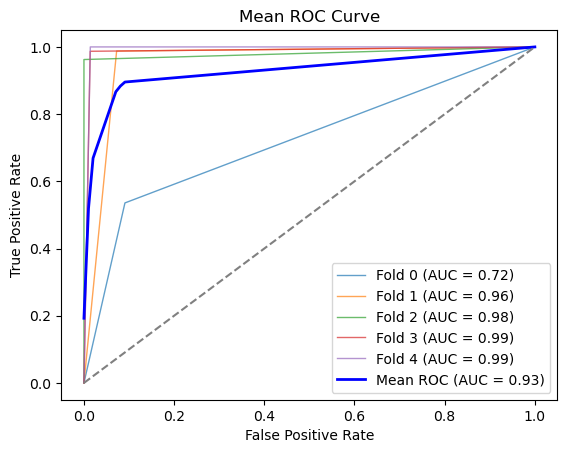

Cross-validation Accuracy: [0.699999988079071, 0.9599999785423279, 0.9798657894134521, 0.9865771532058716, 0.9932885766029358]
Average Accuracy: 0.9239462971687317
Std Accuracy: 0.11252535958925362

Cross-validation Loss: [1.3289682865142822, 0.10483995825052261, 0.06563929468393326, 0.07247686386108398, 0.029308849945664406]
Average Loss: 0.3202466506510973
Std Loss: 0.5049314723063574

Cross-validation AUC: [0.7224025974025973, 0.9575952764358562, 0.98125, 0.9865620490620491, 0.9929577464788732]
Average AUC: 0.9281535338758753
Std AUC: 0.10356702119576236

Cross-validation F1-score: [0.6666666666666666, 0.963855421686747, 0.9808917197452229, 0.987012987012987, 0.9936305732484076]
Average F1-score: 0.9184114736720062
Std F1 score: 0.12626041500680188

Cross-validation precision: [0.8823529411764706, 0.9411764705882353, 1.0, 0.987012987012987, 0.9873417721518988]
Average Precision: 0.9595768341859182
Std Precision: 0.043496596714454175

Cross-validation Recall: [0.5357142857142857, 0.9

In [18]:
import time

# Lists to store running times for each fold
fold_runtimes = []


n_folds = 5 
kf = KFold(n_splits=5, shuffle=True, random_state=10)

accuracies = []
losses = []
auc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
confusion_matrices=[]

# Initialize dictionaries to store metrics for each class across folds
class_metrics = {metric: {} for metric in ['precision', 'recall', 'f1-score', 'support', 'specificity']}


# Lists to store metrics for each fold
all_train_accuracy = []
all_val_accuracy = []
all_train_loss = []
all_val_loss = []

train_images = x_train
train_labels = y_train


for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f"Training on Fold {fold + 1}...")
    start_time = time.time() 
#for train_index, val_index in kf.split(train_images):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = train_images[train_index], train_images[val_index]
    y_train_fold, y_val_fold = train_labels[train_index], train_labels[val_index]
    
    # Train the model on the training data
    history = model.fit(X_train_fold, y_train_fold, epochs=40, batch_size=16,validation_data=(X_val_fold, y_val_fold), verbose=1)
    
    
    end_time = time.time()  # Record end time
    fold_runtime = end_time - start_time  # Calculate duration
    fold_runtimes.append(fold_runtime)  # Store duration for this fold
    
         # Collect training history for accuracy and loss
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
#     train_accuracy = history.history['binary_accuracy']
#     val_accuracy = history.history['val_binary_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
     # Append the metrics for this fold to the lists
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)

    
    # Evaluate the model on the test set for this fold
    test_loss, test_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracies.append(test_accuracy)
    losses.append(test_loss)
    
    
    
    # Evaluate the model on the validation data
    val_preds = model.predict(X_val_fold)
    val_acc = accuracy_score(np.argmax(y_val_fold, axis=1), np.argmax(val_preds, axis=1))
    
    
    auc_score = roc_auc_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    auc_scores.append(auc_score)
    
    f1 = f1_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    f1_scores.append(f1)
    
    precision = precision_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    precision_scores.append(precision)
    
    recall = recall_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    recall_scores.append(recall)
    
    
    cm = confusion_matrix(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    # print(cm)
    confusion_matrices.append(cm)

     # Calculate specificity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)
    

    # Generate classification report for detailed metrics
    report = classification_report(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1), output_dict=True)
    for cls, metrics in report.items():
        if cls.isdigit():  # Ensure the key is a class (digits)
            if cls not in class_metrics['precision']:
                for metric in class_metrics:
                    class_metrics[metric][cls] = []
            class_metrics['precision'][cls].append(metrics['precision'])
            class_metrics['recall'][cls].append(metrics['recall'])
            class_metrics['f1-score'][cls].append(metrics['f1-score'])
            class_metrics['support'][cls].append(metrics['support'])

    # Calculate specificity for each class and add to class metrics
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        class_metrics['specificity'].setdefault(str(i), []).append(specificity)
        
#     # Append validation accuracy to list
#     cv_scores.append(val_acc)
    
    

    # Calculate ROC curve for this fold and interpolate it to make it smoother
    fpr, tpr, _ = roc_curve(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Plot the AUC-ROC curve for this fold
    #plt.plot(fpr, tpr, label=f'Fold {len(fold_scores)}')
    plt.plot(fpr, tpr, lw=1, alpha=0.7, label='Fold {} (AUC = {:.2f})'.format(fold, auc_score))
 
    
# Calculate and plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

# Optionally, plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Mean ROC (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Optionally, configure the plot for the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()
    
# # Print cross-validation scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))
# print("Standard Deviation of CV Scores:", np.std(cv_scores))


print("Cross-validation Accuracy:", accuracies)
print("Average Accuracy:", np.mean(accuracies))
print("Std Accuracy:", np.std(accuracies))
print()
print("Cross-validation Loss:", losses)
print("Average Loss:", np.mean(losses))
print("Std Loss:", np.std(losses))
print()
print("Cross-validation AUC:", auc_scores)
print("Average AUC:", np.mean(auc_scores))
print("Std AUC:", np.std(auc_scores))
print()
print("Cross-validation F1-score:", f1_scores)
print("Average F1-score:", np.mean(f1_scores))
print("Std F1 score:", np.std(f1_scores))
print()
print("Cross-validation precision:", precision_scores)
print("Average Precision:", np.mean(precision_scores))
print("Std Precision:", np.std(precision_scores))
print()
print("Cross-validation Recall:", recall_scores)
print("Average Recall:", np.mean(recall_scores))
print("Std Recall:", np.std(recall_scores))
print()
print("Cross-validation Specificity:", specificity_scores)
print("Average Specificity:", np.mean(specificity_scores))
print("Std Specificity:", np.std(specificity_scores))
print()
print("Fold Runtimes (seconds):", fold_runtimes)
print("Average Runtime:", np.mean(fold_runtimes))
print("Standard Deviation of Runtimes:", np.std(fold_runtimes))

Training on Fold 1...
Epoch 1/40
38/38 [==============================] - 24s 521ms/step - loss: 0.6371 - accuracy: 0.6482 - val_loss: 0.9121 - val_accuracy: 0.4933
Epoch 2/40
38/38 [==============================] - 20s 523ms/step - loss: 0.4134 - accuracy: 0.7990 - val_loss: 1.9066 - val_accuracy: 0.4600
Epoch 3/40
38/38 [==============================] - 68s 2s/step - loss: 0.2727 - accuracy: 0.8995 - val_loss: 2.0190 - val_accuracy: 0.4867
Epoch 4/40
38/38 [==============================] - 52s 1s/step - loss: 0.1512 - accuracy: 0.9430 - val_loss: 1.0343 - val_accuracy: 0.7067
Epoch 5/40
38/38 [==============================] - 31s 810ms/step - loss: 0.2287 - accuracy: 0.9079 - val_loss: 0.9465 - val_accuracy: 0.7067
Epoch 6/40
38/38 [==============================] - 27s 708ms/step - loss: 0.2078 - accuracy: 0.9112 - val_loss: 4.7333 - val_accuracy: 0.5400
Epoch 7/40
38/38 [==============================] - 25s 662ms/step - loss: 0.2324 - accuracy: 0.9112 - val_loss: 0.6099 - val_

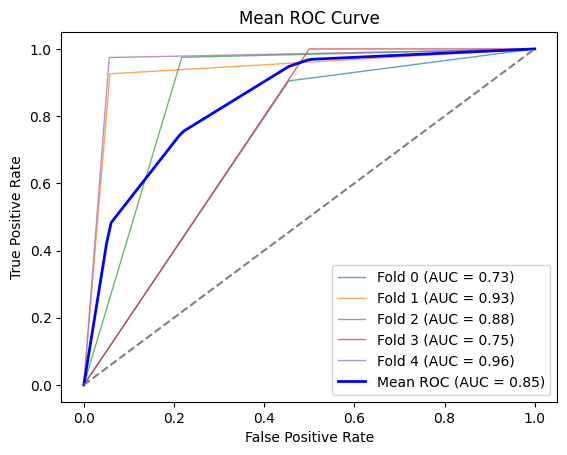

Cross-validation Accuracy: [0.746666669845581, 0.9333333373069763, 0.8859060406684875, 0.7583892345428467, 0.9597315192222595]
Average Accuracy: 0.8568053603172302
Std Accuracy: 0.08844596089957023

Cross-validation Loss: [1.1046741008758545, 0.2323995977640152, 0.46650633215904236, 0.877249002456665, 0.1175130158662796]
Average Loss: 0.5596684098243714
Std Loss: 0.3766096325278302

Cross-validation AUC: [0.725108225108225, 0.9339774557165862, 0.878804347826087, 0.75, 0.9590104730949801]
Average AUC: 0.8493801003491758
Std AUC: 0.0952483289348859

Cross-validation F1-score: [0.8, 0.9375, 0.9017341040462428, 0.8105263157894737, 0.9620253164556962]
Average F1-score: 0.8823571472582825
Std F1 score: 0.06588715489402741

Cross-validation precision: [0.7169811320754716, 0.9493670886075949, 0.8387096774193549, 0.6814159292035398, 0.95]
Average Precision: 0.8272947654611922
Std Precision: 0.11272822136026303

Cross-validation Recall: [0.9047619047619048, 0.9259259259259259, 0.975, 1.0, 0.9743

In [18]:
import time

# Lists to store running times for each fold
fold_runtimes = []


n_folds = 5 
kf = KFold(n_splits=5, shuffle=True, random_state=10)

accuracies = []
losses = []
auc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
confusion_matrices=[]

# Initialize dictionaries to store metrics for each class across folds
class_metrics = {metric: {} for metric in ['precision', 'recall', 'f1-score', 'support', 'specificity']}


# Lists to store metrics for each fold
all_train_accuracy = []
all_val_accuracy = []
all_train_loss = []
all_val_loss = []

train_images = x_train
train_labels = y_train


for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f"Training on Fold {fold + 1}...")
    start_time = time.time() 
#for train_index, val_index in kf.split(train_images):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = train_images[train_index], train_images[val_index]
    y_train_fold, y_val_fold = train_labels[train_index], train_labels[val_index]
    
    # Train the model on the training data
    history = model.fit(X_train_fold, y_train_fold, epochs=40, batch_size=16,validation_data=(X_val_fold, y_val_fold), verbose=1)
    
    
    end_time = time.time()  # Record end time
    fold_runtime = end_time - start_time  # Calculate duration
    fold_runtimes.append(fold_runtime)  # Store duration for this fold
    
         # Collect training history for accuracy and loss
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
#     train_accuracy = history.history['binary_accuracy']
#     val_accuracy = history.history['val_binary_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
     # Append the metrics for this fold to the lists
    all_train_accuracy.append(train_accuracy)
    all_val_accuracy.append(val_accuracy)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)

    
    # Evaluate the model on the test set for this fold
    test_loss, test_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracies.append(test_accuracy)
    losses.append(test_loss)
    
    
    
    # Evaluate the model on the validation data
    val_preds = model.predict(X_val_fold)
    val_acc = accuracy_score(np.argmax(y_val_fold, axis=1), np.argmax(val_preds, axis=1))
    
    
    auc_score = roc_auc_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    auc_scores.append(auc_score)
    
    f1 = f1_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    f1_scores.append(f1)
    
    precision = precision_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    precision_scores.append(precision)
    
    recall = recall_score(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    recall_scores.append(recall)
    
    
    cm = confusion_matrix(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    print(cm)
    confusion_matrices.append(cm)

     # Calculate specificity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)
    

    # Generate classification report for detailed metrics
    report = classification_report(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1), output_dict=True)
    
    print(report)
    for cls, metrics in report.items():
        if cls.isdigit():  # Ensure the key is a class (digits)
            if cls not in class_metrics['precision']:
                for metric in class_metrics:
                    class_metrics[metric][cls] = []
            class_metrics['precision'][cls].append(metrics['precision'])
            class_metrics['recall'][cls].append(metrics['recall'])
            class_metrics['f1-score'][cls].append(metrics['f1-score'])
            class_metrics['support'][cls].append(metrics['support'])

    # Calculate specificity for each class and add to class metrics
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        class_metrics['specificity'].setdefault(str(i), []).append(specificity)
        
#     # Append validation accuracy to list
#     cv_scores.append(val_acc)
    
    

    # Calculate ROC curve for this fold and interpolate it to make it smoother
    fpr, tpr, _ = roc_curve(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1))
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Plot the AUC-ROC curve for this fold
    #plt.plot(fpr, tpr, label=f'Fold {len(fold_scores)}')
    plt.plot(fpr, tpr, lw=1, alpha=0.7, label='Fold {} (AUC = {:.2f})'.format(fold, auc_score))
 
    
# Calculate and plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

# Optionally, plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Mean ROC (AUC = {:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Optionally, configure the plot for the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()
    
# # Print cross-validation scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))
# print("Standard Deviation of CV Scores:", np.std(cv_scores))


print("Cross-validation Accuracy:", accuracies)
print("Average Accuracy:", np.mean(accuracies))
print("Std Accuracy:", np.std(accuracies))
print()
print("Cross-validation Loss:", losses)
print("Average Loss:", np.mean(losses))
print("Std Loss:", np.std(losses))
print()
print("Cross-validation AUC:", auc_scores)
print("Average AUC:", np.mean(auc_scores))
print("Std AUC:", np.std(auc_scores))
print()
print("Cross-validation F1-score:", f1_scores)
print("Average F1-score:", np.mean(f1_scores))
print("Std F1 score:", np.std(f1_scores))
print()
print("Cross-validation precision:", precision_scores)
print("Average Precision:", np.mean(precision_scores))
print("Std Precision:", np.std(precision_scores))
print()
print("Cross-validation Recall:", recall_scores)
print("Average Recall:", np.mean(recall_scores))
print("Std Recall:", np.std(recall_scores))
print()
print("Cross-validation Specificity:", specificity_scores)
print("Average Specificity:", np.mean(specificity_scores))
print("Std Specificity:", np.std(specificity_scores))
print()
print("Fold Runtimes (seconds):", fold_runtimes)
print("Average Runtime:", np.mean(fold_runtimes))
print("Standard Deviation of Runtimes:", np.std(fold_runtimes))

In [19]:
for metric in class_metrics:
    if metric != 'specificity':  # Specificity already printed
        print(f"Cross-validation {metric} per class:")
        for cls, values in class_metrics[metric].items():
            print(f"Class {cls}: {np.mean(values):.4f} ± {np.std(values):.4f}")

Cross-validation precision per class:
Class 0: 0.9338 ± 0.0639
Class 1: 0.8273 ± 0.1127
Cross-validation recall per class:
Class 0: 0.7428 ± 0.1895
Class 1: 0.9560 ± 0.0351
Cross-validation f1-score per class:
Class 0: 0.8142 ± 0.1290
Class 1: 0.8824 ± 0.0659
Cross-validation support per class:
Class 0: 69.4000 ± 2.0591
Class 1: 80.0000 ± 2.4495


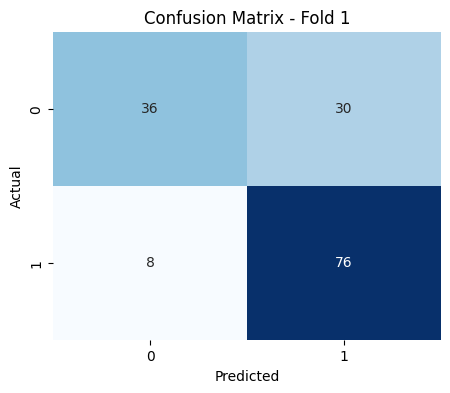

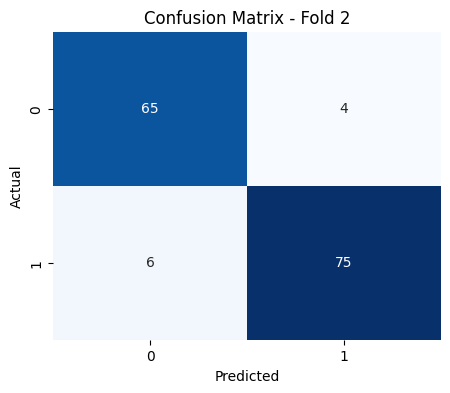

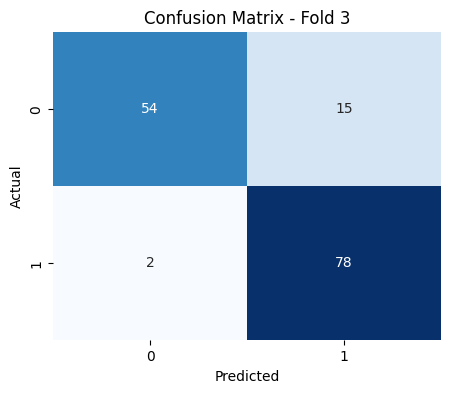

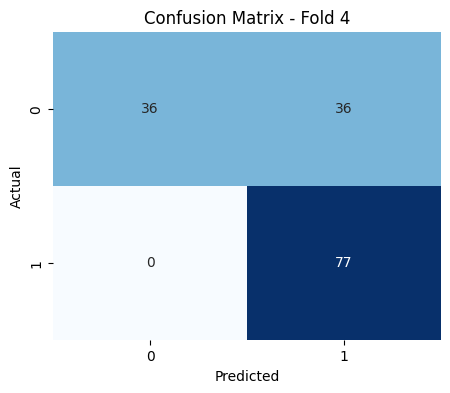

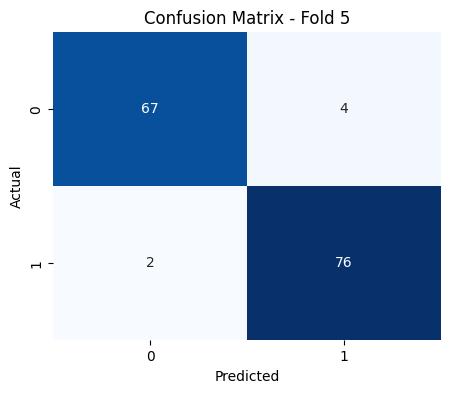

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate through the confusion matrices for each fold
for fold_num, cm in enumerate(confusion_matrices, start=1):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    plt.show()

### Evlaution on test set

In [21]:
start_time = time.time()
y_pred = model.predict(x_val)
# y_pred = model.predict(test_images)

end_time = time.time()
prediction_time = end_time - start_time
predd = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels if needed



accuracy = accuracy_score(np.argmax(y_val, axis=1), predd)

# Compute F1 score
f1 = f1_score(np.argmax(y_val, axis=1), predd, average='weighted')

# Compute recall
recall = recall_score(np.argmax(y_val, axis=1), predd, average='weighted')
precision = precision_score(np.argmax(y_val, axis=1), predd, average='weighted')
#auc = roc_auc_score(np.argmax(y_val, axis=1), y_pred)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
cm = confusion_matrix(np.argmax(y_val,axis=1),np.argmax(y_pred,axis=1))
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("Accuray:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("F1 Score:", f1)
print("Recall:", recall)
print("specificity:", specificity)
print("Prediction Time:", prediction_time, "seconds")

6/6 [==============================] - 1s 227ms/step
Accuray: 0.839572192513369
Precision: 0.8459893048128342
AUC: 0.9172966781214204
F1 Score: 0.8392967326790857
Recall: 0.839572192513369
specificity: 0.7835051546391752
Prediction Time: 1.8084843158721924 seconds


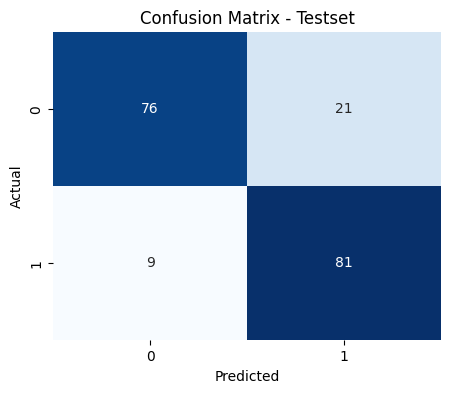

In [22]:
#cm = confusion_matrix(np.argmax(test_labels,axis=1),predd)
cm = confusion_matrix(np.argmax(y_val,axis=1),predd)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - Testset")
plt.show()

In [24]:
from tensorflow.keras.models import load_model
model.save('mobileNetU.h5')

In [23]:
report = classification_report(np.argmax(y_val_fold,axis=1),np.argmax(val_preds,axis=1), output_dict=True)

In [24]:
print(report)

{'0': {'precision': 0.9710144927536232, 'recall': 0.9436619718309859, 'f1-score': 0.9571428571428572, 'support': 71.0}, '1': {'precision': 0.95, 'recall': 0.9743589743589743, 'f1-score': 0.9620253164556962, 'support': 78.0}, 'accuracy': 0.959731543624161, 'macro avg': {'precision': 0.9605072463768116, 'recall': 0.9590104730949801, 'f1-score': 0.9595840867992766, 'support': 149.0}, 'weighted avg': {'precision': 0.9600136173523977, 'recall': 0.959731543624161, 'f1-score': 0.9596987754408534, 'support': 149.0}}
